# Introduction

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
from IPython.display import Image
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn import over_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from scipy.stats import uniform
import pickle
import xgboost as xgb

sns.set(rc={'figure.figsize':(16,8)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.18.5
pandas version :  1.1.3
seaborn version :  0.11.0


# Load and Describe Data

## Load Data

In [2]:
data = pd.read_csv("startup data.csv")
print('There are', str(len(data)), 'rows of data in this dataset')
print('There are', str(data.shape[1]), 'features in this dataset')
data.head(5)

There are 923 rows of data in this dataset
There are 49 features in this dataset


,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [3]:
data['status'].value_counts()

acquired    597
closed      326
Name: status, dtype: int64

In [4]:
acquired = data[data['status']=='acquired']
closed = data[data['status']=='closed']

In [5]:
print('1. The percentage of successed startup are ' + str(round((len(acquired)/len(data))*100,2)) + '%')
print('2. The percentage of failed startup are ' + str(round((len(closed)/len(data))*100,2)) + '%')

1. The percentage of successed startup are 64.68%
2. The percentage of failed startup are 35.32%


## Describe Data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

**Conclusion**</br>
* Dataframe have 49 columns
* Dataframe have 923 rows
* Total categorical columns are 14 columns
* Total numerical columns are 35 columns
* There are 5 columns that have a missing value (`unnamed: 6`,`closed_at`, `age_first_milestone_year  `, `age_last_milestone_year`, and `state_code.1`)
* `labels` column is the target for this dataset

# Data Understanding: Exploratory Data Analysis (EDA)

## Statistical Summary

### Separation of Categorical and Numerical Data 

In [7]:
# assign the categorical data into cats object
cats = ['state_code', 'zip_code', 'id', 'city', 'Unnamed: 6', 
        'name', 'founded_at', 'closed_at', 'first_funding_at', 
        'last_funding_at','state_code.1', 'category_code', 'object_id', 
        'status']

# assign the numerical data into nums object
nums = ['Unnamed: 0', 'latitude', 'longitude', 'labels', 'age_first_funding_year', 
        'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 
        'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 
        'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 
        'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
        'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 
        'has_roundC', 'has_roundD', 'avg_participants', 'is_top500']

#without one hot encoding features
wo_onehot = ['Unnamed: 0', 'latitude', 'longitude', 'labels', 'age_first_funding_year', 
             'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 
             'relationships', 'funding_rounds', 'funding_total_usd', 'milestones',
             'avg_participants', 'is_top500' ]

### Statistical Numerical Data

In [8]:
data[wo_onehot].describe()

,Unnamed: 0,latitude,longitude,labels,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,avg_participants,is_top500
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,771.000000,771.000000,923.000000,923.000000,9.230000e+02,923.000000,923.000000,923.000000
mean,572.297941,38.517442,-103.539212,0.646804,2.235630,3.931456,3.055353,4.754423,7.710726,2.310943,2.541975e+07,1.841820,2.838586,0.809317
std,333.585431,3.741497,22.394167,0.478222,2.510449,2.967910,2.977057,3.212107,7.265776,1.390922,1.896344e+08,1.322632,1.874601,0.393052
min,1.000000,25.752358,-122.756956,0.000000,-9.046600,-9.046600,-14.169900,-7.005500,0.000000,1.000000,1.100000e+04,0.000000,1.000000,0.000000
25%,283.500000,37.388869,-122.198732,0.000000,0.576700,1.669850,1.000000,2.411000,3.000000,1.000000,2.725000e+06,1.000000,1.500000,1.000000
50%,577.000000,37.779281,-118.374037,1.000000,1.446600,3.528800,2.520500,4.476700,5.000000,2.000000,1.000000e+07,2.000000,2.500000,1.000000
75%,866.500000,40.730646,-77.214731,1.000000,3.575350,5.560250,4.686300,6.753400,10.000000,3.000000,2.472500e+07,3.000000,3.800000,1.000000
max,1153.000000,59.335232,18.057121,1.000000,21.895900,21.895900,24.684900,24.684900,63.000000,10.000000,5.700000e+09,8.000000,16.000000,1.000000


* `Unnamed: 0`, `labels`, `age_first_funding_year`, `age_last_funding_year`, `age_first_milestone_year`, `relationships`, `age_last_milestone_year`, `funding_total_usd` (probably has outliers)

* `latitude` and `longitude` is a geospatial location

* `funding_rounds`, `milestones`, `avg_participants`, `is_top500` probably normal distribution

### Statistical Categorical Data

In [9]:
data[cats].describe()

,state_code,zip_code,id,city,Unnamed: 6,name,founded_at,closed_at,first_funding_at,last_funding_at,state_code.1,category_code,object_id,status
count,923,923,923,923,430,923,923,335,923,923,922,923,923,923
unique,35,382,922,221,252,922,217,202,585,680,35,35,922,2
top,CA,94107,c:28482,San Francisco,San Francisco CA 94105,Redwood Systems,1/1/2003,6/1/2013,1/1/2008,1/1/2008,CA,software,c:28482,acquired
freq,488,30,2,128,12,2,55,25,18,11,487,153,2,597


* `state_code` and `state_code.1` has exactly same values to each other with **35** unique values with majority is CA.
* `zip_code` has been covered up by `city` with data majority in `zip_code` is 94107 and **382** unique value.
* `id` and `object_id` has exactly the same values to each other with **922** unique values.
* `Unnamed: 6` has been covered up by `city` with data majority is San Fransisco.
* `name` has **922** unique values with Redwood Systems as majority.
* `founded_at` has **217** unique values with 1/1/2003 as data majority.
* `closed_at` has **202** unique values with 6/2/2013 as data majority.
* `first_funding_at` has **585** unique values with 1/1/2008 as data majority.
* `last_funding_at` has **680** unique values with 1/1/2008 as data majority.
* `category_code` has **35** unique values with software as data majority.
* `status` has **2** unique values with acquired as data majority.

## Check Missing Values

In [10]:
# assign features with missing value into data_missing object
data_missing = data.isnull().sum().reset_index()
data_missing.columns = ['feature','missing_value']
data_missing = data_missing[data_missing['missing_value'] > 0].reset_index(drop=True)
data_missing['percentage'] = (data_missing['missing_value']/len(data))*100
data_missing

,feature,missing_value,percentage
0,Unnamed: 6,493,53.412784
1,closed_at,588,63.705309
2,age_first_milestone_year,152,16.468039
3,age_last_milestone_year,152,16.468039
4,state_code.1,1,0.108342


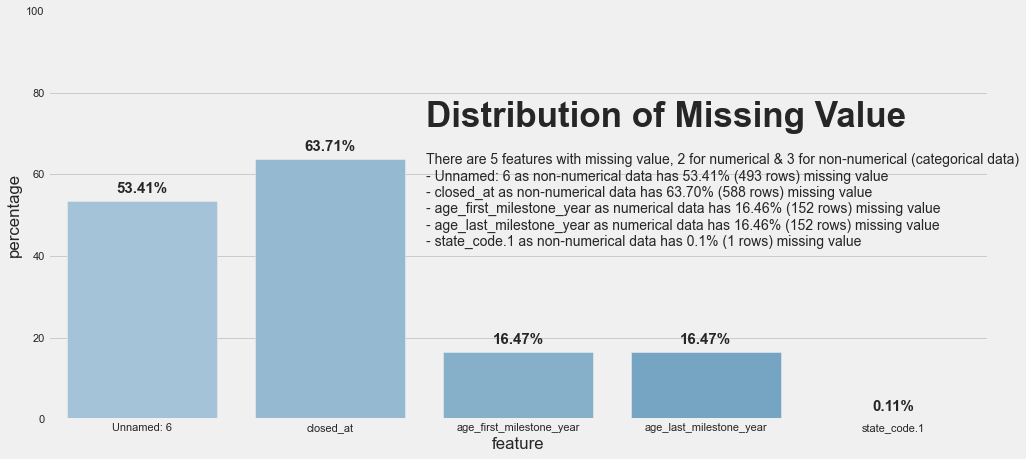

In [11]:
fig, ax = plt.subplots(figsize = (15,7))

mvalue_plot = sns.barplot(x='feature', y='percentage', data=data_missing,
           palette = sns.color_palette('Blues_d', n_colors = 13, desat = 1))

ax.set_ylim(0,100)

for p in mvalue_plot.patches:
    height = p.get_height()
    mvalue_plot.text(x = p.get_x() + (p.get_width()/2),
                y = height + 2,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center', fontsize = 15, fontweight='bold')

title = '''Distribution of Missing Value'''
fig.text(x=0.43, y=0.65, s = title, fontsize = 35, weight = 'bold')

text = '''
There are 5 features with missing value, 2 for numerical & 3 for non-numerical (categorical data)
- Unnamed: 6 as non-numerical data has 53.41% (493 rows) missing value
- closed_at as non-numerical data has 63.70% (588 rows) missing value
- age_first_milestone_year as numerical data has 16.46% (152 rows) missing value
- age_last_milestone_year as numerical data has 16.46% (152 rows) missing value
- state_code.1 as non-numerical data has 0.1% (1 rows) missing value

'''
fig.text(x=0.43, y=0.35, s = text, fontsize=14);

#plt.savefig('fig/Distribution of Missing Value.png', tight_box=True)

## Check Duplicated Data

In [12]:
data.duplicated().sum()

0

**In the raw data, there are no duplicate values**

## Drop Columns

In [13]:
data_clean = data.drop(['Unnamed: 0', 'Unnamed: 6', 'id', 'object_id', 'latitude', 'longitude',
                       'zip_code', 'state_code.1', 'status'], axis=1)

## Fix Missing Values

In [14]:
# assign features with missing value into data_missing1 object
data_missing1 = data_clean.isnull().sum().reset_index()
data_missing1.columns = ['feature','missing_value']
data_missing1 = data_missing1[data_missing1['missing_value'] > 0].reset_index(drop=True)
data_missing1['percentage'] = (data_missing1['missing_value']/len(data))*100
data_missing1

,feature,missing_value,percentage
0,closed_at,588,63.705309
1,age_first_milestone_year,152,16.468039
2,age_last_milestone_year,152,16.468039


In [15]:
# change column to date type
data_clean.founded_at=pd.to_datetime(data_clean.founded_at)
data_clean.closed_at=pd.to_datetime(data_clean.closed_at)
data_clean.first_funding_at=pd.to_datetime(data_clean.first_funding_at)
data_clean.last_funding_at=pd.to_datetime(data_clean.last_funding_at)

data_clean.head(3)

,state_code,city,name,labels,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
0,CA,San Diego,Bandsintown,1,2007-01-01,NaT,2009-04-01,2010-01-01,2.2493,3.0027,...,0,1,0,1,0,0,0,0,1.00,0
1,CA,Los Gatos,TriCipher,1,2000-01-01,NaT,2005-02-14,2009-12-28,5.1260,9.9973,...,0,0,1,0,0,1,1,1,4.75,1
2,CA,San Diego,Plixi,1,2009-03-18,NaT,2010-03-30,2010-03-30,1.0329,1.0329,...,0,0,0,0,1,0,0,0,4.00,1


In [16]:
# fill missing value in closed_at with closed_at + 1 day so we know that the startup haven't been failed yet
from datetime import timedelta
data_clean['closed_at'] = data_clean['closed_at'].fillna(data_clean['closed_at'].max() + timedelta(days=1))

In [17]:
# Assign startup age in days to age column
data_clean['age'] = data_clean['closed_at'] - data_clean['founded_at']
# age from success startup
data_clean['age'].max()

Timedelta('10368 days 00:00:00')

In [18]:
data_clean['age'] = data_clean['age'].astype(str)
data_clean[['age','suffix']] = data_clean.age.str.split(" ",expand=True)
data_clean = data_clean.drop(['suffix'], axis=1)
data_clean['age'] = data_clean['age'].astype(int)

In [19]:
# we must get the absolute value of this four columns
data_clean["age_first_funding_year"]=np.abs(data_clean["age_first_funding_year"])
data_clean["age_last_funding_year"]=np.abs(data_clean["age_last_funding_year"])
data_clean["age_first_milestone_year"]=np.abs(data_clean["age_first_milestone_year"])
data_clean["age_last_milestone_year"]=np.abs(data_clean["age_last_milestone_year"])

In [20]:
data_clean.head()

,state_code,city,name,labels,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,age
0,CA,San Diego,Bandsintown,1,2007-01-01,2013-10-31,2009-04-01,2010-01-01,2.2493,3.0027,...,1,0,1,0,0,0,0,1.0000,0,2495
1,CA,Los Gatos,TriCipher,1,2000-01-01,2013-10-31,2005-02-14,2009-12-28,5.1260,9.9973,...,0,1,0,0,1,1,1,4.7500,1,5052
2,CA,San Diego,Plixi,1,2009-03-18,2013-10-31,2010-03-30,2010-03-30,1.0329,1.0329,...,0,0,0,1,0,0,0,4.0000,1,1688
3,CA,Cupertino,Solidcore Systems,1,2002-01-01,2013-10-31,2005-02-17,2007-04-25,3.1315,5.3151,...,0,0,0,0,1,1,1,3.3333,1,4321
4,CA,San Francisco,Inhale Digital,0,2010-08-01,2012-10-01,2010-08-01,2012-04-01,0.0000,1.6685,...,0,1,1,0,0,0,0,1.0000,1,792


In [21]:
# for columns with missing value i will fill it by median() function
data_clean["age_first_milestone_year"].fillna((data_clean["age_first_milestone_year"].median()), inplace=True)
data_clean["age_last_milestone_year"].fillna((data_clean["age_last_milestone_year"].median()), inplace=True)

In [22]:
data_clean.isnull().sum()

state_code                  0
city                        0
name                        0
labels                      0
founded_at                  0
closed_at                   0
first_funding_at            0
last_funding_at             0
age_first_funding_year      0
age_last_funding_year       0
age_first_milestone_year    0
age_last_milestone_year     0
relationships               0
funding_rounds              0
funding_total_usd           0
milestones                  0
is_CA                       0
is_NY                       0
is_MA                       0
is_TX                       0
is_otherstate               0
category_code               0
is_software                 0
is_web                      0
is_mobile                   0
is_enterprise               0
is_advertising              0
is_gamesvideo               0
is_ecommerce                0
is_biotech                  0
is_consulting               0
is_othercategory            0
has_VC                      0
has_angel 

In [23]:
# We also simplify the total_funding_usd value
data_clean['funding_total_usd'] = data_clean['funding_total_usd']/100000

**There is no columns with missing value anymore, so we decided to proceed further**

## Graphical Approach

### Univariate Analysis

#### Numerical Data

In [24]:
#assign numerical data into dat_num object
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(data_clean.select_dtypes(include=numerics).columns)
print(data_clean.select_dtypes(include=numerics).shape)
data_num = data_clean.select_dtypes(include=numerics)
data_num.head(3)

Index(['labels', 'age_first_funding_year', 'age_last_funding_year',
       'age_first_milestone_year', 'age_last_milestone_year', 'relationships',
       'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile',
       'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce',
       'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC',
       'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD',
       'avg_participants', 'is_top500', 'age'],
      dtype='object')

(923, 33)


,labels,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,age
0,1,2.2493,3.0027,4.6685,6.7041,3,3,3.75,3,1,...,1,0,1,0,0,0,0,1.00,0,2495
1,1,5.1260,9.9973,7.0055,7.0055,9,4,401.00,1,1,...,0,1,0,0,1,1,1,4.75,1,5052
2,1,1.0329,1.0329,1.4575,2.2055,5,1,26.00,2,1,...,0,0,0,1,0,0,0,4.00,1,1688


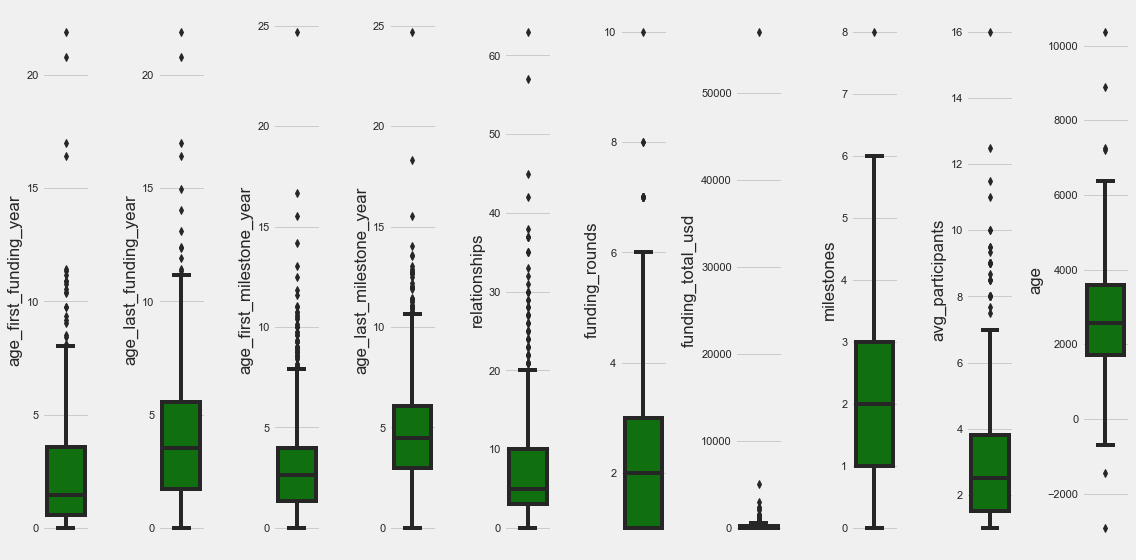

In [25]:
# look at the distribution of data with boxplot
# We only use continuous variables and exclude the boolean value
features = ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year',
            'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd',
            'milestones', 'avg_participants', 'age']
for i in range(0, len(features)):
    plt.subplot(1, 10, i+1)
    sns.boxplot(y=data_clean[features[i]],color='green',orient='v')
    plt.tight_layout()
#plt.savefig('fig/Boxplot.png', tight_box=True)

As we can see `age_first_funding_year`, `age_last_funding_year`, `age_first_milestone_year`, `age_last_milestone_year`, `funding_rounds`, `funding_total_usd`, `milestones`, `avg_participants`, and `age` absolutely have an outlier

#### Non-Numerical (Categorical)

In [26]:
# assign categorical data into data_cat object
display(data_clean.select_dtypes(include=['object']).columns)
print(data_clean.select_dtypes(include=object).shape)
data_cat = data_clean.select_dtypes(include=['object'])
data_cat.head(3)

Index(['state_code', 'city', 'name', 'category_code'], dtype='object')

(923, 4)


,state_code,city,name,category_code
0,CA,San Diego,Bandsintown,music
1,CA,Los Gatos,TriCipher,enterprise
2,CA,San Diego,Plixi,web


### Multivariate Analysis

#### Numerical Data

<AxesSubplot:>

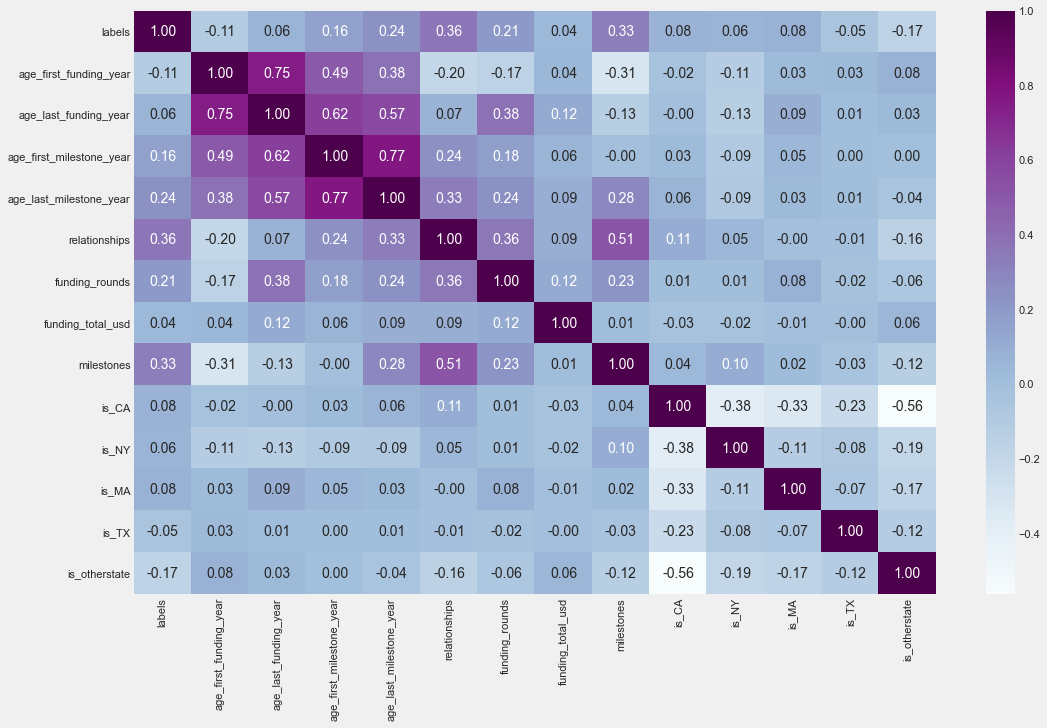

In [27]:
# We divide the correlation matrix to simplify the graph and make it readable
features = ['labels', 'age_first_funding_year', 'age_last_funding_year', 
            'age_first_milestone_year', 'age_last_milestone_year', 'relationships',
            'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY',
            'is_MA', 'is_TX', 'is_otherstate']
corr_= data_clean[features].corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")
#plt.savefig('fig/correlation matrix.png', tight_box=True);

<AxesSubplot:>

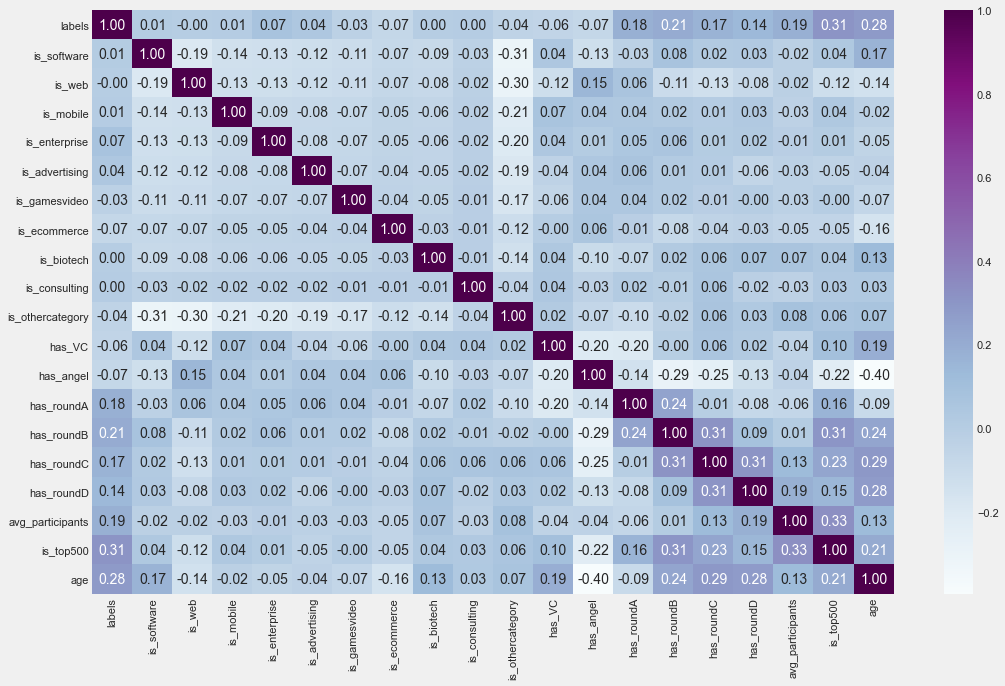

In [28]:
# We divide the correlation matrix to simplify the graph and make it readable
features = ['labels','is_software', 'is_web', 'is_mobile', 
            'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
            'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 
            'has_roundC', 'has_roundD', 'avg_participants', 'is_top500', 'age']
corr_= data_clean[features].corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")
#plt.savefig('fig/correlation matrix.png', tight_box=True);

As we can see there is some features with positive correlation with target, such as `age_last_funding_year`, `age_first_milestone_year`, `age_last_milestone_year`, `relationship`, `funding_rounds`, `milestones`, `funding_total_usd`, `is_CA`, `is_NY`, `is_MA`, `is_software`, `is_mobile`, `is_enterprise`, `is_advertising`, `has_roundA`, `has_roundB`, `has_roundC`, `has_roundD`, `avg_participants`, `is_top500`, and `age`

## Logaritmic Transformation

**Let's use logaritmic transformation to make the values have more normal distribution**

In [29]:
features = ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year',
            'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd',
            'milestones', 'avg_participants', 'age']
df_pre = data_clean.copy()
for var in features:
    df_pre['log_'+var]= (data_clean[var]+1).apply(np.log)

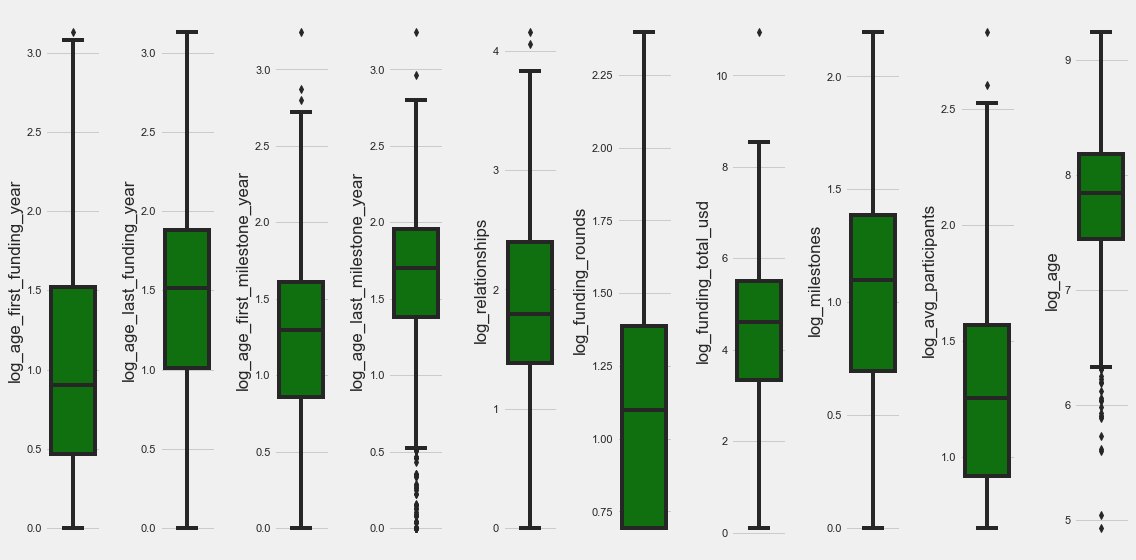

In [30]:
# Now let's take a look once more to this feature that have been transform
featuress = ['log_age_first_funding_year', 'log_age_last_funding_year', 'log_age_first_milestone_year',
            'log_age_last_milestone_year', 'log_relationships', 'log_funding_rounds', 'log_funding_total_usd',
            'log_milestones', 'log_avg_participants', 'log_age']
for i in range(0, len(featuress)):
    plt.subplot(1, 10, i+1)
    sns.boxplot(y=df_pre[featuress[i]],color='green',orient='v')
    plt.tight_layout()
#plt.savefig('fig/Boxplot.png', tight_box=True)

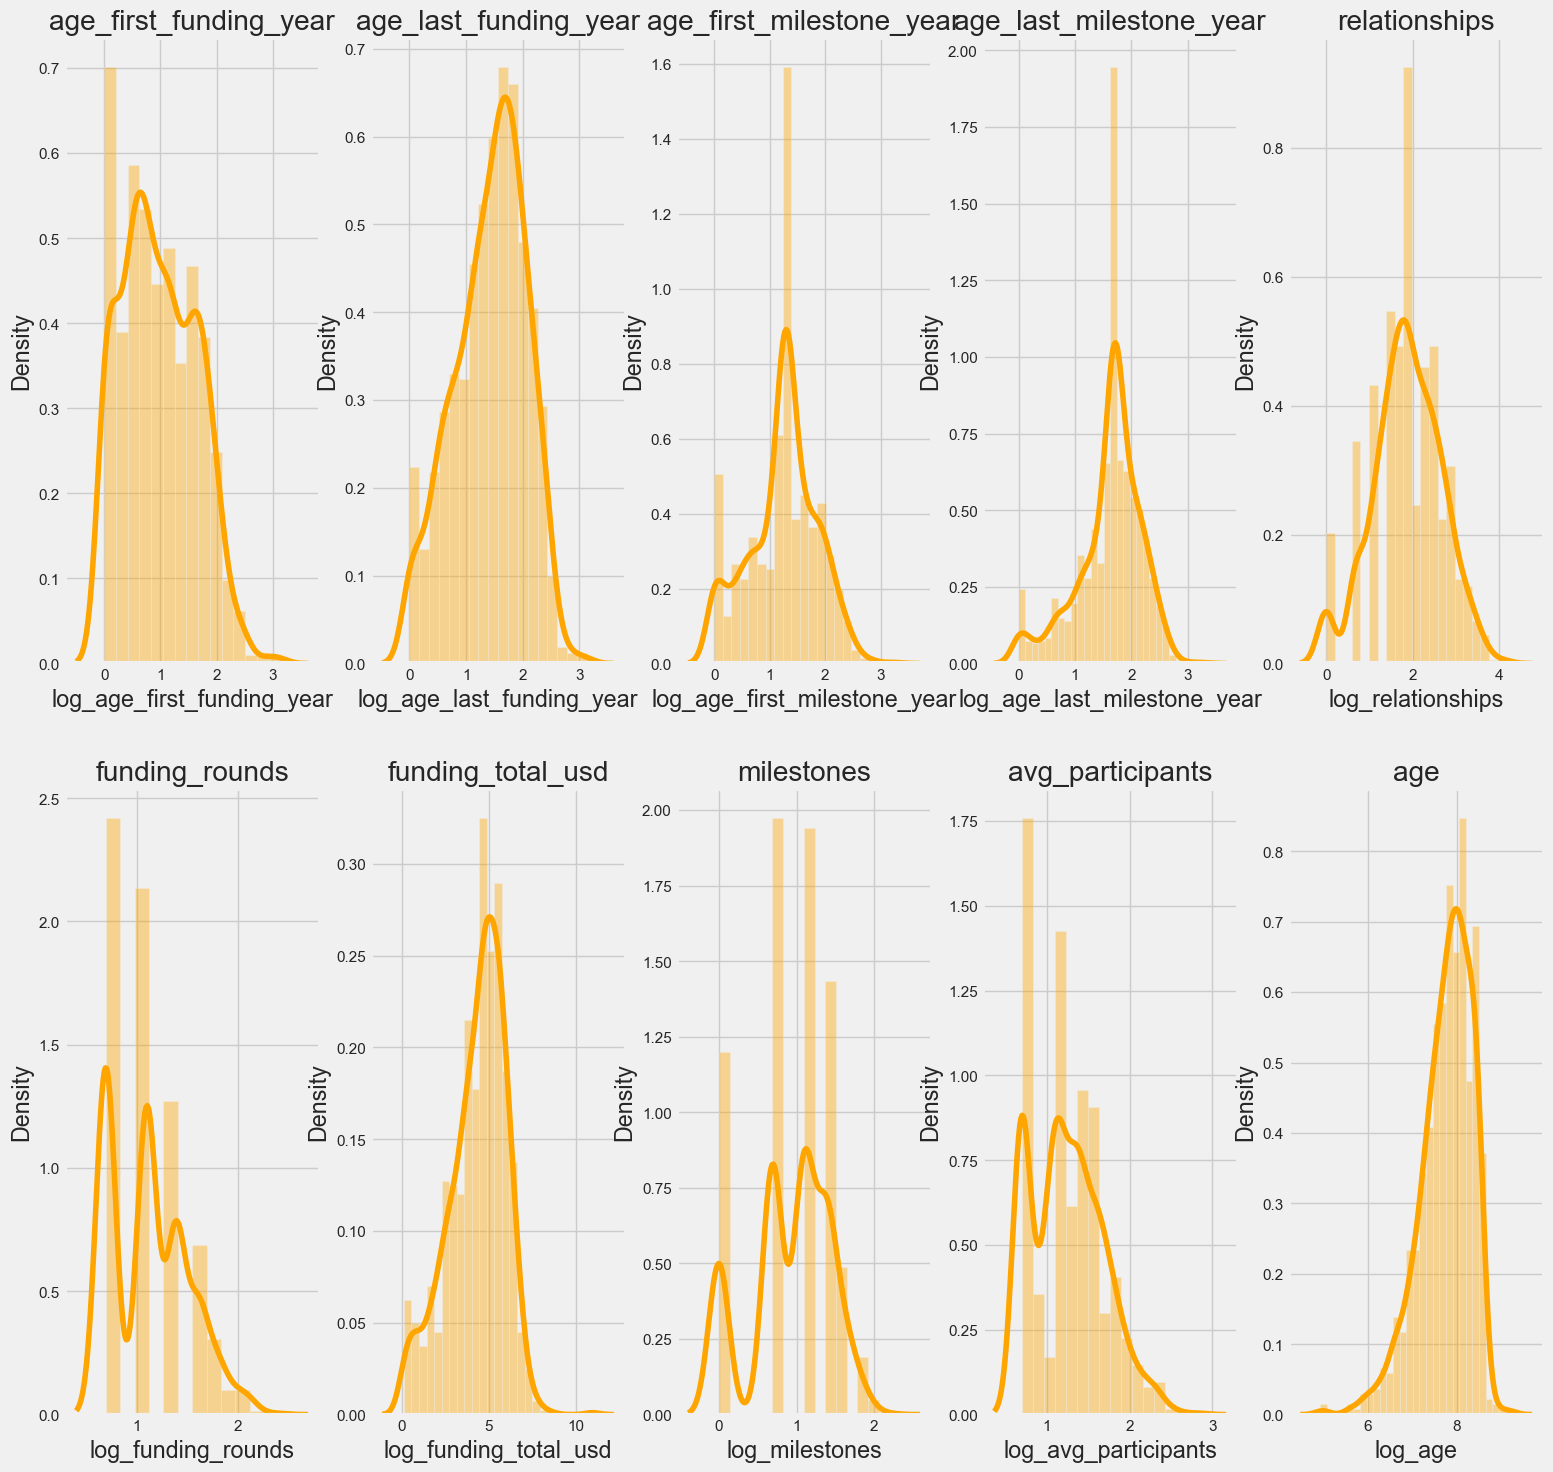

In [31]:
# now let's use distplot to see the distribution of features values
plt.figure(figsize=(17,17),dpi=100)
for i in range(len(featuress)):
    plt.subplot(2,5,i+1)
    plt.title("{}". format(features[i]))
    sns.distplot(df_pre[featuress[i]], color="orange");

**Okay, now it's finally distribute more normal than before, but some features still have some outlier left**

## Normalization

In [32]:
for var in features:
    df_pre['nor_'+var] = MinMaxScaler().fit_transform(df_pre[var].values.reshape(len(df_pre),1))

In [33]:
df_pre.head()

,state_code,city,name,labels,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,...,nor_age_first_funding_year,nor_age_last_funding_year,nor_age_first_milestone_year,nor_age_last_milestone_year,nor_relationships,nor_funding_rounds,nor_funding_total_usd,nor_milestones,nor_avg_participants,nor_age
0,CA,San Diego,Bandsintown,1,2007-01-01,2013-10-31,2009-04-01,2010-01-01,2.2493,3.0027,...,0.102727,0.137135,0.189124,0.271587,0.047619,0.222222,0.000064,0.375,0.000000,0.407600
1,CA,Los Gatos,TriCipher,1,2000-01-01,2013-10-31,2005-02-14,2009-12-28,5.1260,9.9973,...,0.234108,0.456583,0.283797,0.283797,0.142857,0.333333,0.007033,0.125,0.250000,0.600000
2,CA,San Diego,Plixi,1,2009-03-18,2013-10-31,2010-03-30,2010-03-30,1.0329,1.0329,...,0.047173,0.047173,0.059044,0.089346,0.079365,0.000000,0.000454,0.250,0.200000,0.346877
3,CA,Cupertino,Solidcore Systems,1,2002-01-01,2013-10-31,2005-02-17,2007-04-25,3.1315,5.3151,...,0.143018,0.242744,0.243173,0.243173,0.079365,0.222222,0.007016,0.125,0.155553,0.544996
4,CA,San Francisco,Inhale Digital,0,2010-08-01,2012-10-01,2010-08-01,2012-04-01,0.0000,1.6685,...,0.000000,0.076201,0.001556,0.001556,0.031746,0.111111,0.000226,0.125,0.000000,0.279458


In [34]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   state_code                    923 non-null    object        
 1   city                          923 non-null    object        
 2   name                          923 non-null    object        
 3   labels                        923 non-null    int64         
 4   founded_at                    923 non-null    datetime64[ns]
 5   closed_at                     923 non-null    datetime64[ns]
 6   first_funding_at              923 non-null    datetime64[ns]
 7   last_funding_at               923 non-null    datetime64[ns]
 8   age_first_funding_year        923 non-null    float64       
 9   age_last_funding_year         923 non-null    float64       
 10  age_first_milestone_year      923 non-null    float64       
 11  age_last_milestone_year       92

# Machine Learning Modeling and Evaluation

## Split Train Test

<AxesSubplot:>

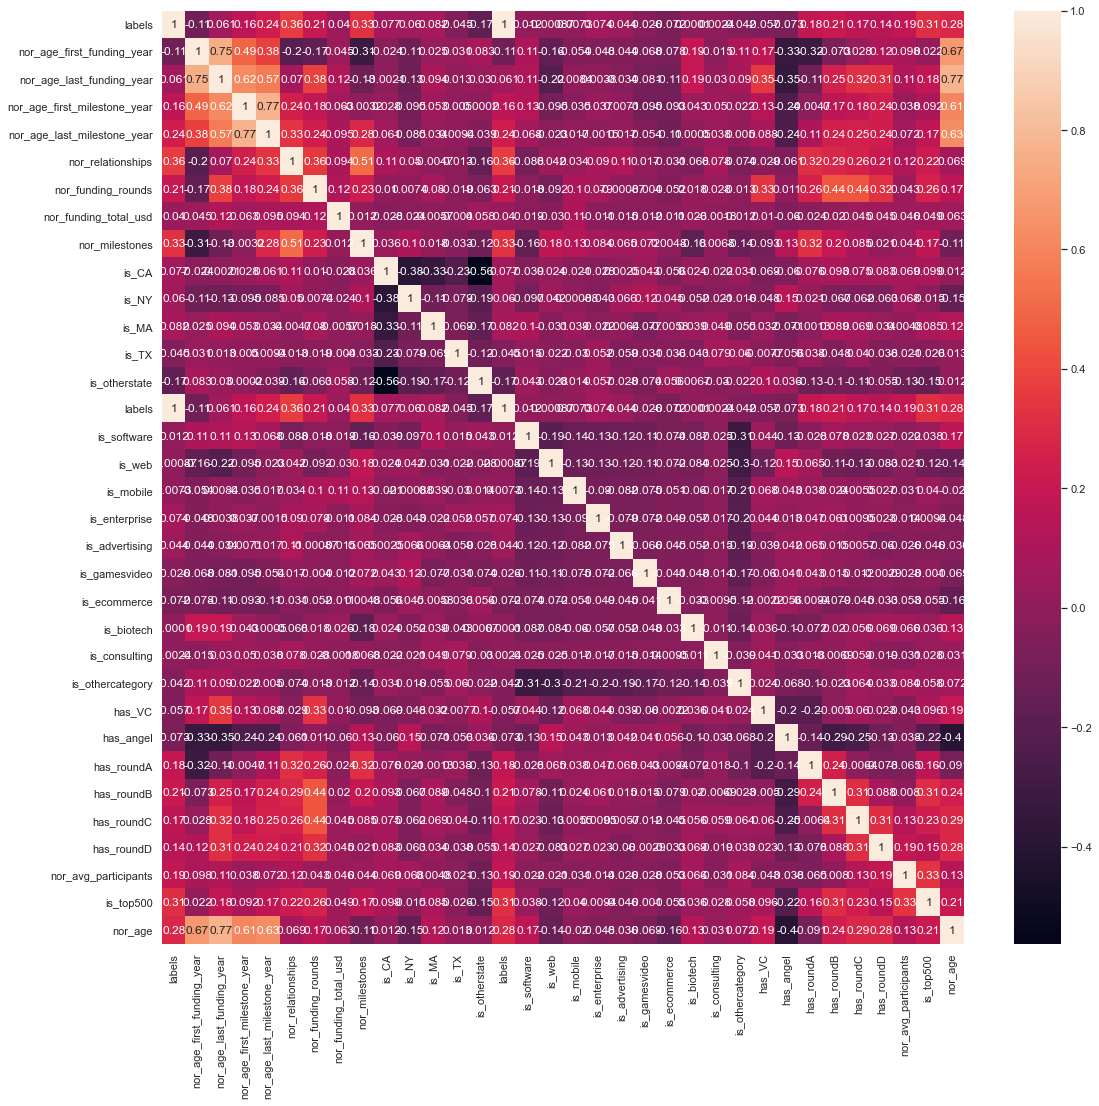

In [35]:
sns.set(rc={'figure.figsize':(16,16)})
sns.heatmap(df_pre[['labels', 'nor_age_first_funding_year', 'nor_age_last_funding_year', 
            'nor_age_first_milestone_year', 'nor_age_last_milestone_year', 'nor_relationships',
            'nor_funding_rounds', 'nor_funding_total_usd', 'nor_milestones', 'is_CA', 'is_NY',
            'is_MA', 'is_TX', 'is_otherstate', 'labels','is_software', 'is_web', 'is_mobile', 
            'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
            'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 
            'has_roundC', 'has_roundD', 'nor_avg_participants', 'is_top500', 'nor_age']].corr(), annot=True)
#plt.savefig('fig/split train test.png', tight_box=True)

In [36]:
x = df_pre[['nor_age_first_funding_year', 'nor_age_last_funding_year', 
            'nor_age_first_milestone_year', 'nor_age_last_milestone_year', 'nor_relationships',
            'nor_funding_rounds', 'nor_funding_total_usd', 'nor_milestones', 'is_CA', 'is_NY',
            'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 
            'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
            'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 
            'has_roundC', 'has_roundD', 'nor_avg_participants', 'is_top500', 'nor_age']]
y = df_pre['labels']

In [37]:
#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.5, random_state=42) 

In [38]:
print(df_pre.shape)
print(xtrain.shape)
print(xtest.shape)

(923, 61)
(461, 32)
(462, 32)


## Random Forest Algorithm

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier (random_state=42)
rf_model = rf.fit(xtrain, ytrain)

In [40]:
y_predicted = rf.predict(xtest)
y_predicted_train = rf.predict(xtrain)
#eval
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

print('\nclassification report')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report
              precision    recall  f1-score   support

           0       0.82      0.60      0.70       164
           1       0.81      0.93      0.87       298

    accuracy                           0.81       462
   macro avg       0.82      0.77      0.78       462
weighted avg       0.82      0.81      0.81       462

Random Forest: ROC AUC =  76.7 %
Random Forest: Precision =  81.0 %
Random Forest: Recall =  93.0 %
Random Forest: Accuracy =  81.4 %
Random Forest: F1-Score =  86.6 %


array([[ 99,  65],
       [ 21, 277]], dtype=int64)

In [41]:
#Save Machine Learning Model
import pickle
pickle.dump(rf_model, open('RandomForest.pkl', 'wb'))

In [42]:
#Load and print model score
loaded_model = pickle.load(open('RandomForest.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.8138528138528138


In [43]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  100.0 %
test score :  81.39 %


In [44]:
#define function for roc auc curve
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

ROC AUC Score:  76.7 %


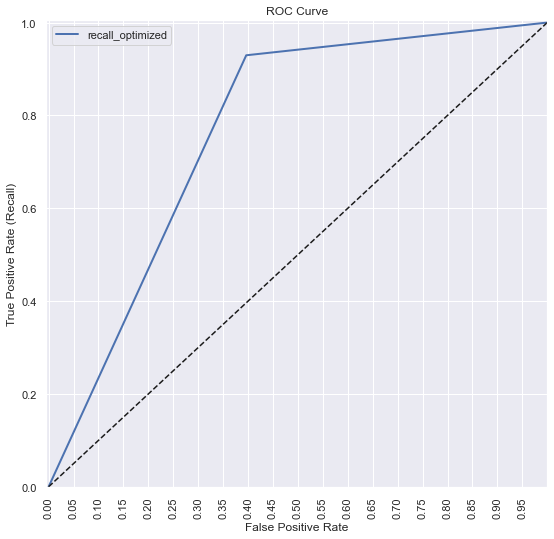

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/Random Forest ROC Curve.png')

In [46]:
#Define function to see precision and recall threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [47]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_predicted)

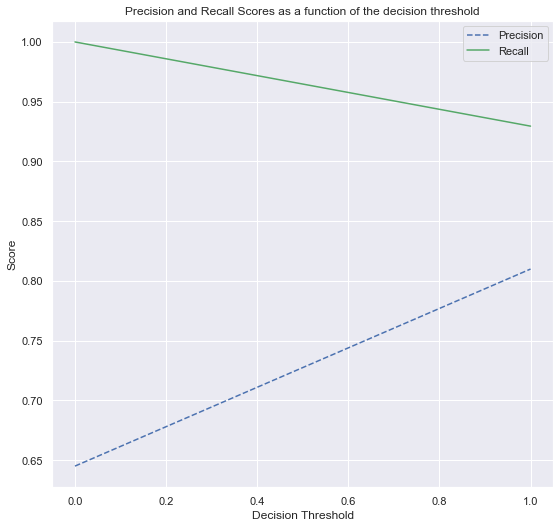

In [48]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold RF.png')

Text(0.5, 1.0, 'feature importance score')

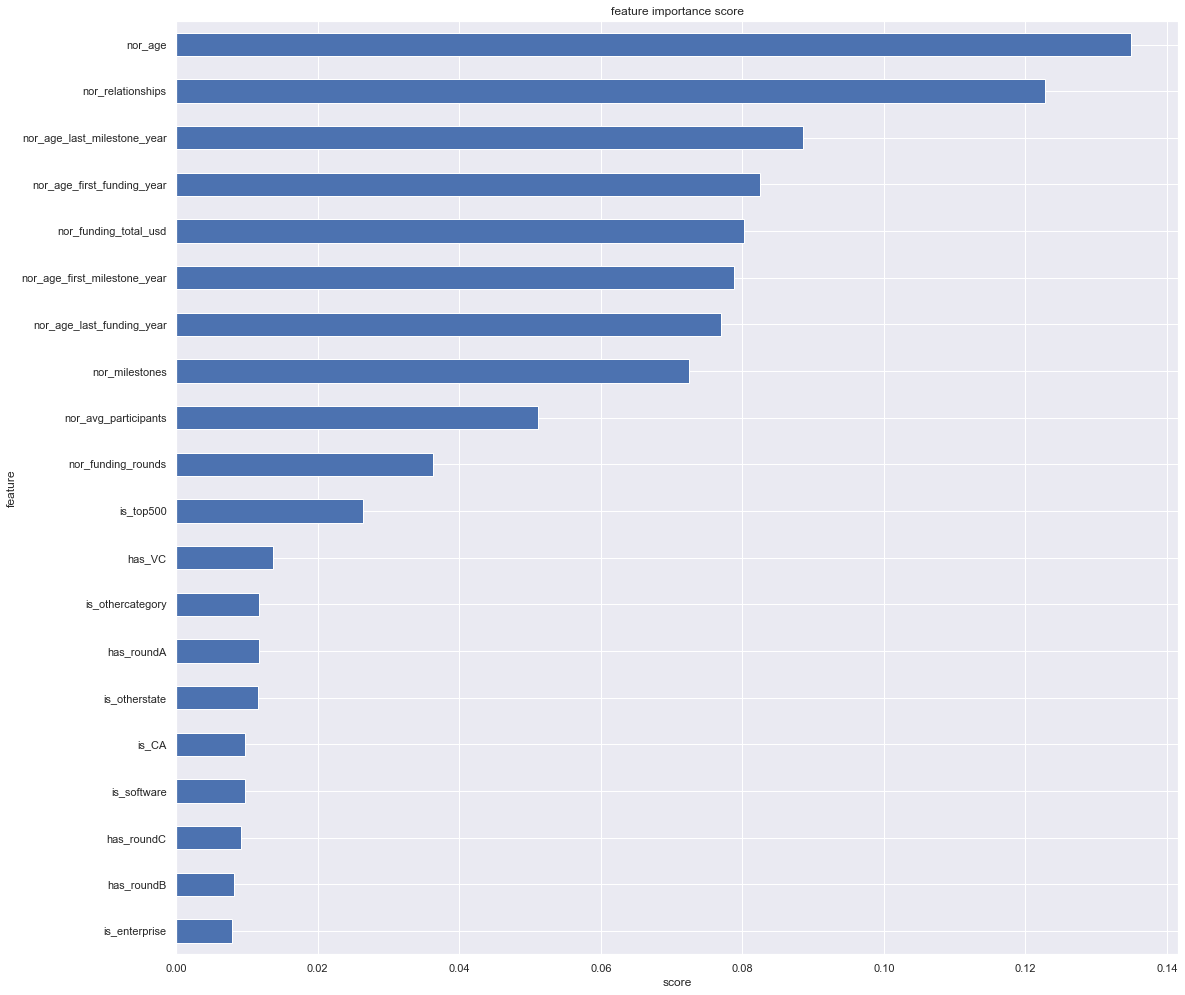

In [49]:
feat_importances = pd.Series(rf.feature_importances_, index=x.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

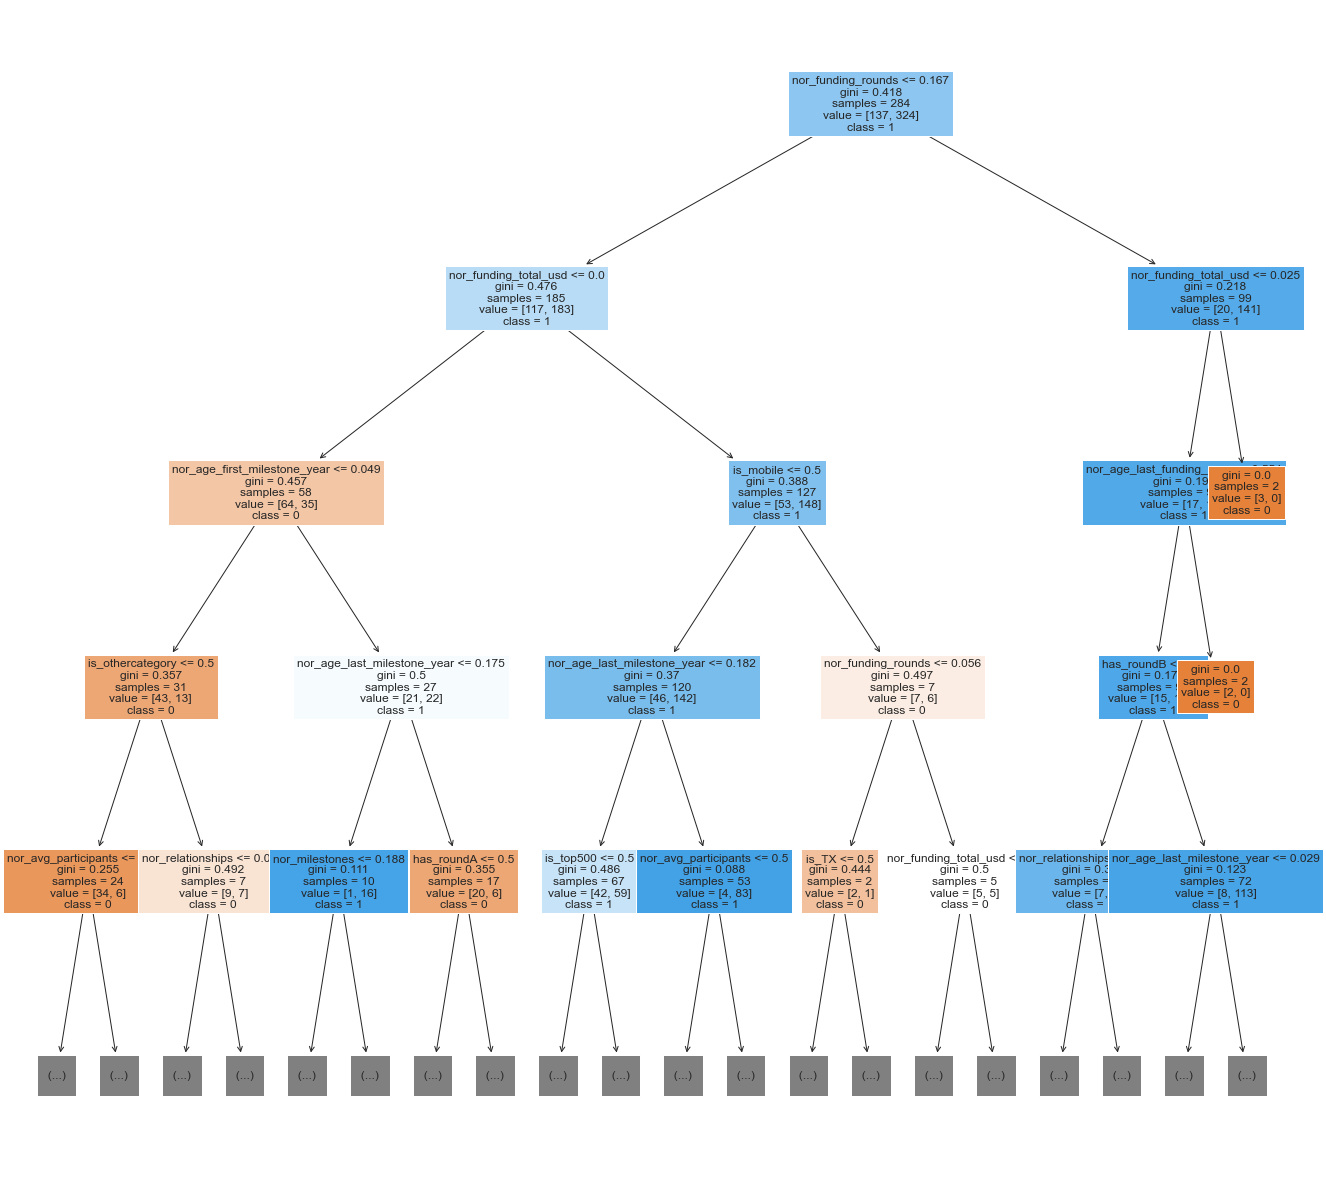

In [50]:
from sklearn import tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(rf.estimators_[2],
               feature_names = x.columns.tolist(), 
               class_names=['0','1'],
               filled = True, max_depth=4, fontsize=12)
plt.show()

### Random Forest Hyperparameter Tuning

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

#List Hyperparameters yang akan diuji
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)] # Number of trees in random forest
max_features = ['auto', 'sqrt', 'log2'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)] # Minimum number of samples required to split a node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)] # Minimum number of samples required at each leaf node
bootstrap = [True] # Method of selecting samples for training each tree
n_jobs = [-1]

#Insert it into dictionary
hyperparameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_jobs':n_jobs}

# Init random forest dengan randomsearch, cross validation = 5
rf = RandomForestClassifier(random_state=42)
clf = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42)

#Fitting Model
best_model = clf.fit(xtrain,ytrain)

#Nilai hyperparameters terbaik
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])


#Prediksi menggunakan model baru
y_predicted = best_model.predict(xtest)#Check performa dari model
print('\nclassification report')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


Best n_estimators: 400
Best max_features: log2
Best max_depth: 110
Best min_samples_split: 4
Best min_samples_leaf: 1

classification report
              precision    recall  f1-score   support

           0       0.82      0.60      0.70       164
           1       0.81      0.93      0.87       298

    accuracy                           0.81       462
   macro avg       0.82      0.77      0.78       462
weighted avg       0.82      0.81      0.81       462

Random Forest: ROC AUC =  76.7 %
Random Forest: Precision =  81.0 %
Random Forest: Recall =  93.0 %
Random Forest: Accuracy =  81.4 %
Random Forest: F1-Score =  86.6 %


array([[ 99,  65],
       [ 21, 277]], dtype=int64)

In [52]:
import pickle
pickle.dump(best_model, open('RandomForest_model.pkl', 'wb'))

In [53]:
loaded_model = pickle.load(open('RandomForest_model.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.8138528138528138


In [54]:
print('train accuracy : ', loaded_model.score(xtrain, ytrain)*100)
print('test accuracy : ', loaded_model.score(xtest, ytest)*100)

train accuracy :  100.0
test accuracy :  81.38528138528139


ROC AUC Score:  76.7 %


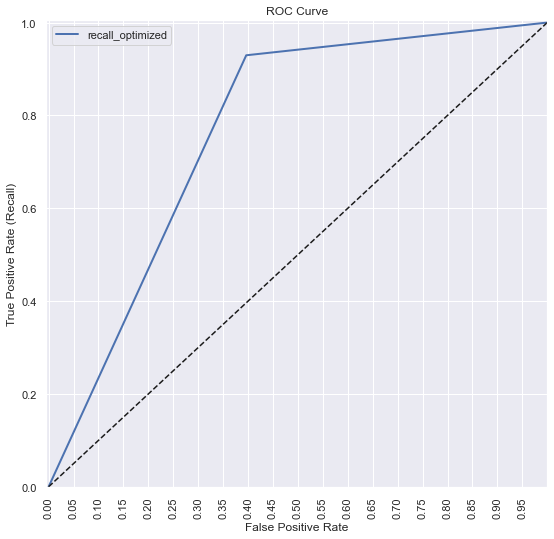

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/RF ROC Curve.png')

In [56]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_predicted)

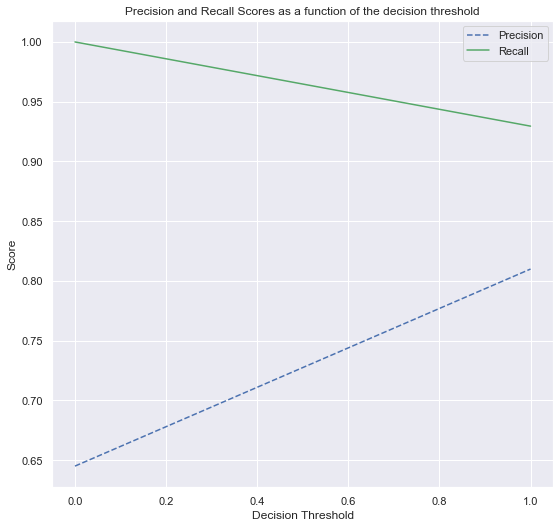

In [57]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold RF.png')

## Decision Tree Algorithm

In [58]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt_model = dt.fit(xtrain,ytrain)
y_predicteddt = dt.predict(xtest)

print('\nclassification report')
print(classification_report(ytest, y_predicteddt)) # generate the precision, recall, f-1 score, num
print('Decision Tree: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicteddt)*100,1)), '%')
print('Decision Tree: Precision = ',str(round(precision_score(ytest, y_predicteddt)*100,1)), '%')
print('Decision Tree: Recall = ',str(round(recall_score(ytest, y_predicteddt)*100,1)), '%')
print('Decision Tree: Accuracy = ',str(round(accuracy_score(ytest, y_predicteddt)*100,1)), '%')
print('Decision Tree: F1-Score = ',str(round(f1_score(ytest, y_predicteddt)*100,1)), '%')
confusion_matrix(ytest, y_predicteddt)


classification report
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       164
           1       0.82      0.82      0.82       298

    accuracy                           0.76       462
   macro avg       0.74      0.74      0.74       462
weighted avg       0.76      0.76      0.76       462

Decision Tree: ROC AUC =  74.0 %
Decision Tree: Precision =  81.5 %
Decision Tree: Recall =  81.5 %
Decision Tree: Accuracy =  76.2 %
Decision Tree: F1-Score =  81.5 %


array([[109,  55],
       [ 55, 243]], dtype=int64)

In [59]:
#Save Machine Learning Model
import pickle
pickle.dump(dt_model, open('DecisionTree.pkl', 'wb'))

In [60]:
#Load and print model score
loaded_model = pickle.load(open('DecisionTree.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.7619047619047619


In [61]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  100.0 %
test score :  76.19 %


ROC AUC Score:  74.0 %


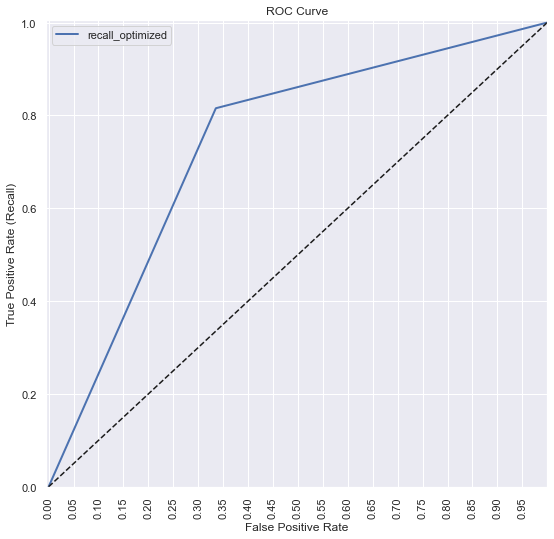

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicteddt)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/Random Forest ROC Curve.png')

In [63]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_predicteddt)

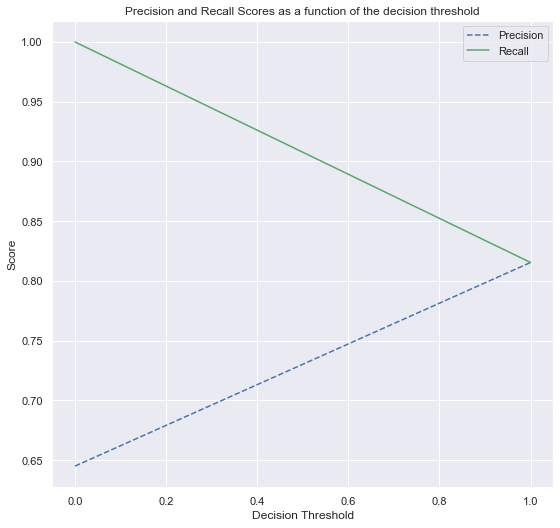

In [64]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold RF.png')

Text(0.5, 1.0, 'feature importance score')

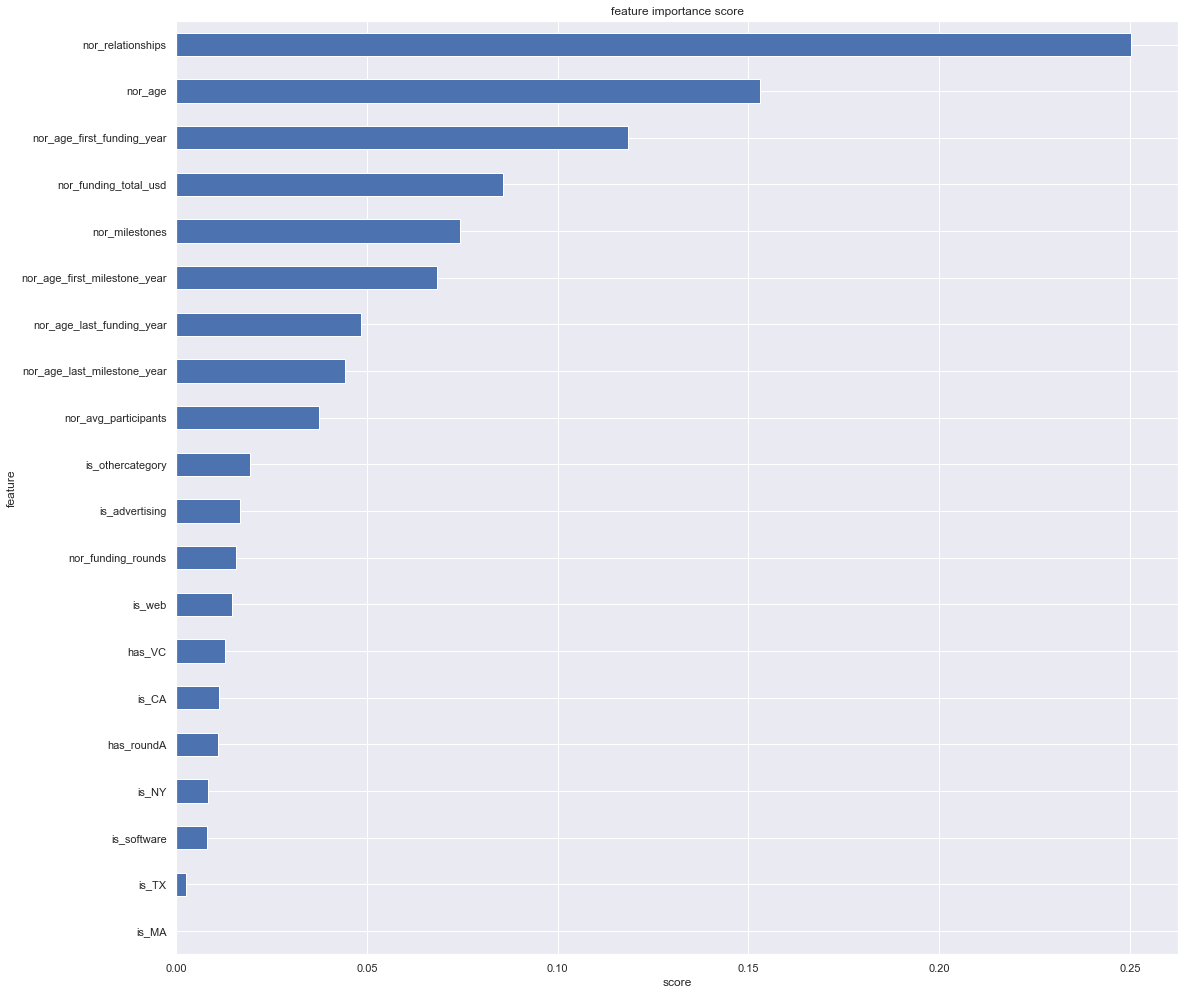

In [65]:
feat_importances = pd.Series(dt.feature_importances_, index=x.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

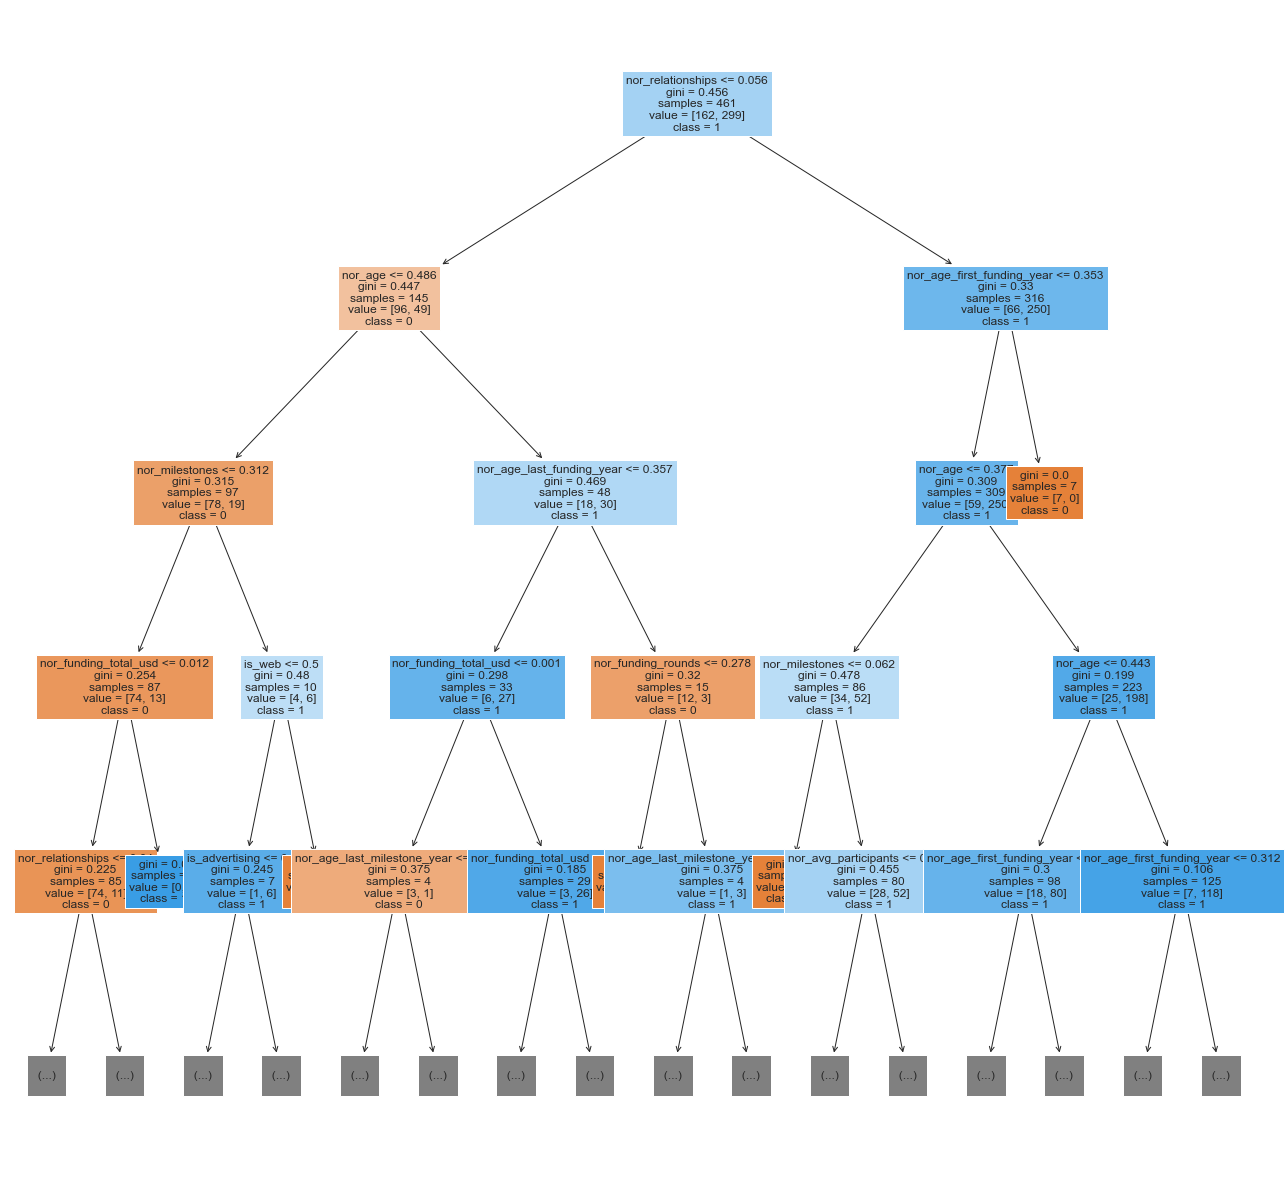

In [66]:
from sklearn import tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(dt,
               feature_names = x.columns.tolist(), 
               class_names=['0','1'],
               filled = True, max_depth=4, fontsize=12)
plt.show()

### Decision Tree Hyperparameter Tuning

In [67]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# list of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion =['entropy']
splitter = ['random']

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'criterion':criterion,
               'splitter': splitter
                }

# Init Logres dengan Gridsearch, cross validation = 5
dt2 = DecisionTreeClassifier(random_state=42)
clf1 = RandomizedSearchCV(dt2, hyperparameters, cv=5, random_state=42)

#Fitting Model
dt_model1 = clf1.fit(xtrain, ytrain)

#Prediksi menggunakan model baru
y_preddt = dt_model1.predict(xtest)#Check performa dari model
print('\nclassification report')
print(classification_report(ytest, y_preddt)) # generate the precision, recall, f-1 score, num
print('Decision Tree: ROC AUC = ',str(round(roc_auc_score(ytest, y_preddt)*100,1)), '%')
print('Decision Tree: Precision = ',str(round(precision_score(ytest, y_preddt)*100,1)), '%')
print('Decision Tree: Recall = ',str(round(recall_score(ytest, y_preddt)*100,1)), '%')
print('Decision Tree: Accuracy = ',str(round(accuracy_score(ytest, y_preddt)*100,1)), '%')
print('Decision Tree: F1-Score = ',str(round(f1_score(ytest, y_preddt)*100,1)), '%')
confusion_matrix(ytest, y_preddt)


classification report
              precision    recall  f1-score   support

           0       0.68      0.55      0.61       164
           1       0.78      0.86      0.81       298

    accuracy                           0.75       462
   macro avg       0.73      0.70      0.71       462
weighted avg       0.74      0.75      0.74       462

Decision Tree: ROC AUC =  70.2 %
Decision Tree: Precision =  77.5 %
Decision Tree: Recall =  85.6 %
Decision Tree: Accuracy =  74.7 %
Decision Tree: F1-Score =  81.3 %


array([[ 90,  74],
       [ 43, 255]], dtype=int64)

In [68]:
#Save Machine Learning Model
import pickle
pickle.dump(dt_model1, open('DecisionTree_model.pkl', 'wb'))

In [69]:
#Load and print model score
loaded_model = pickle.load(open('DecisionTree_model.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.7467532467532467


In [70]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  75.27 %
test score :  74.68 %


ROC AUC Score:  70.2 %


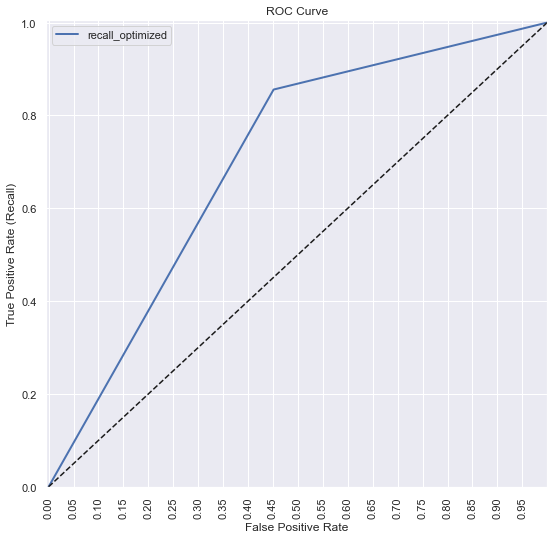

In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_preddt)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/Random Forest ROC Curve.png')

In [72]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_preddt)

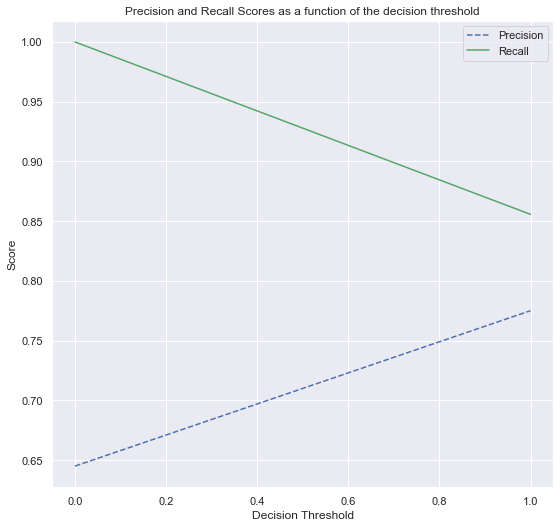

In [73]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold RF.png')

## Logistic Regression Algorithm

In [74]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42, solver = 'liblinear')
logreg_model = logreg.fit(xtrain, ytrain)

In [75]:
# Predict the test data
y_predictedlog = logreg.predict(xtest)
y_predictedlog

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,

In [76]:
'''
The output of a Logistic regression model is a probability. 
We can select a threshold value. 
If the probability is greater than this threshold value, 
the event is predicted to happen otherwise it is predicted not to happen.

To get the probability of the label, repectively for class 0 and 1
'''

y_predicted_proba = logreg.predict_proba(xtest)
y_predicted_proba

array([[0.22885639, 0.77114361],
       [0.46006095, 0.53993905],
       [0.31554832, 0.68445168],
       [0.60660001, 0.39339999],
       [0.30231267, 0.69768733],
       [0.83834107, 0.16165893],
       [0.47613644, 0.52386356],
       [0.28680061, 0.71319939],
       [0.25215511, 0.74784489],
       [0.2297332 , 0.7702668 ],
       [0.64237513, 0.35762487],
       [0.64782305, 0.35217695],
       [0.40279892, 0.59720108],
       [0.578611  , 0.421389  ],
       [0.18334467, 0.81665533],
       [0.21307764, 0.78692236],
       [0.12669282, 0.87330718],
       [0.08912794, 0.91087206],
       [0.28394152, 0.71605848],
       [0.59193906, 0.40806094],
       [0.75240554, 0.24759446],
       [0.38033266, 0.61966734],
       [0.24238545, 0.75761455],
       [0.77410938, 0.22589062],
       [0.38909956, 0.61090044],
       [0.09514593, 0.90485407],
       [0.39555867, 0.60444133],
       [0.26154478, 0.73845522],
       [0.52637765, 0.47362235],
       [0.14525482, 0.85474518],
       [0.

In [77]:
print('\nclassification report')
print(classification_report(ytest, y_predictedlog)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytest, y_predictedlog)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytest, y_predictedlog)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytest, y_predictedlog)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytest, y_predictedlog)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytest, y_predictedlog)*100,1)), '%')
confusion_matrix(ytest, y_predictedlog)


classification report
              precision    recall  f1-score   support

           0       0.73      0.54      0.62       164
           1       0.78      0.89      0.83       298

    accuracy                           0.76       462
   macro avg       0.75      0.71      0.72       462
weighted avg       0.76      0.76      0.75       462

LogReg: ROC AUC =  71.3 %
LogReg: Precision =  77.7 %
LogReg: Recall =  88.9 %
LogReg: Accuracy =  76.4 %
LogReg: F1-Score =  82.9 %


array([[ 88,  76],
       [ 33, 265]], dtype=int64)

In [78]:
#Save Machine Learning Model
import pickle
pickle.dump(logreg_model, open('Logreg.pkl', 'wb'))

In [79]:
#Load and print model score
loaded_model = pickle.load(open('Logreg.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.7640692640692641


In [80]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  79.61 %
test score :  76.41 %


ROC AUC Score:  76.7 %


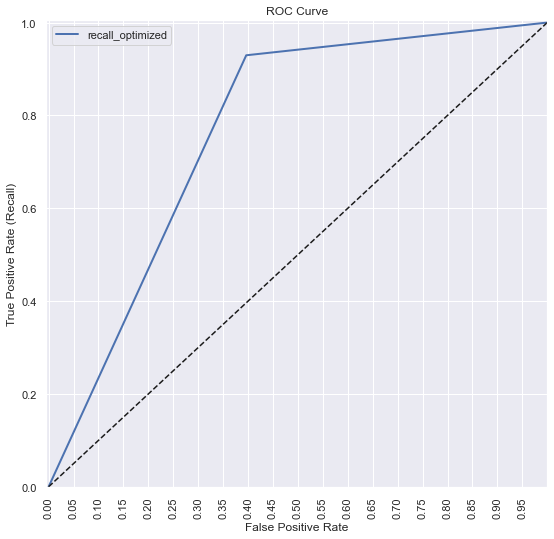

In [81]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/Logreg ROC Curve.png')

In [82]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_predicted)

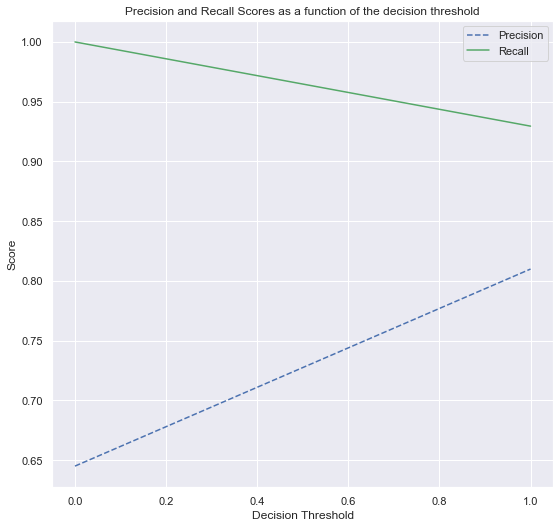

In [83]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold Logreg.png')

### Logistic Regression Hyperparameter Tuning

In [84]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

#List Hyperparameters yang akan diuji
penalty = ['l2']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.

#Menjadikan ke dalam bentuk dictionary
hyperparameters = dict(penalty=penalty, C=C)

# Init Logres dengan Gridsearch, cross validation = 5
logreg2 = LogisticRegression(random_state=42)
clf2 = RandomizedSearchCV(logreg, hyperparameters, cv=5, random_state=42)

#Fitting Model
logreg_model2 = clf2.fit(xtrain, ytrain)

#Nilai hyperparameters terbaik
print('Best Penalty:', logreg_model2.best_estimator_.get_params()['penalty'])
print('Best C:', logreg_model2.best_estimator_.get_params()['C'])

#Prediksi menggunakan model baru
y_predlog = logreg_model2.predict(xtest)#Check performa dari model
print('\nclassification report')
print(classification_report(ytest, y_predlog)) # generate the precision, recall, f-1 score, num
print('Decision Tree: ROC AUC = ',str(round(roc_auc_score(ytest, y_predlog)*100,1)), '%')
print('Decision Tree: Precision = ',str(round(precision_score(ytest, y_predlog)*100,1)), '%')
print('Decision Tree: Recall = ',str(round(recall_score(ytest, y_predlog)*100,1)), '%')
print('Decision Tree: Accuracy = ',str(round(accuracy_score(ytest, y_predlog)*100,1)), '%')
print('Decision Tree: F1-Score = ',str(round(f1_score(ytest, y_predlog)*100,1)), '%')
confusion_matrix(ytest, y_predlog)

Best Penalty: l2
Best C: 0.0001

classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.65      1.00      0.78       298

    accuracy                           0.65       462
   macro avg       0.32      0.50      0.39       462
weighted avg       0.42      0.65      0.51       462

Decision Tree: ROC AUC =  50.0 %
Decision Tree: Precision =  64.5 %
Decision Tree: Recall =  100.0 %
Decision Tree: Accuracy =  64.5 %
Decision Tree: F1-Score =  78.4 %


array([[  0, 164],
       [  0, 298]], dtype=int64)

In [85]:
#Save Machine Learning Model
import pickle
pickle.dump(logreg_model2, open('LogReg_model.pkl', 'wb'))

In [86]:
#Load and print model score
loaded_model = pickle.load(open('LogReg_model.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.645021645021645


In [87]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  64.86 %
test score :  64.5 %


ROC AUC Score:  50.0 %


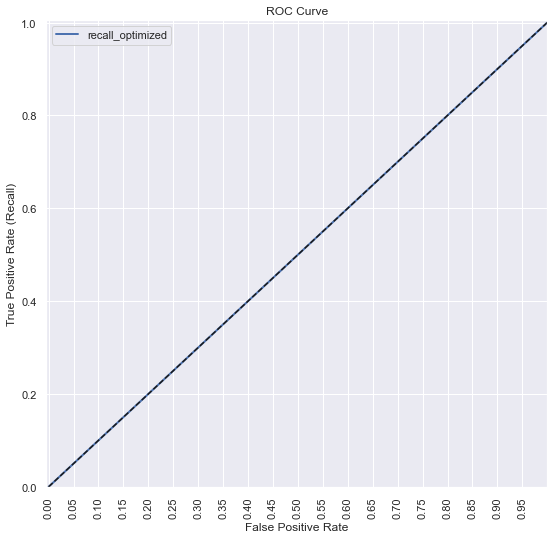

In [88]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predlog)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/Random Forest ROC Curve.png')

In [89]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_predlog)

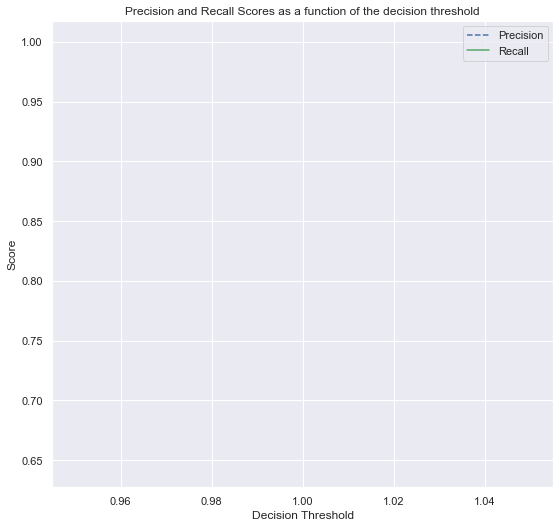

In [90]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold RF.png')

## K-Nearest Neighbors Algorithm

In [91]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_model = knn.fit(xtrain, ytrain)

# Predict Test
ypredk = knn.predict(xtest)

print('\nclassification report')
print(classification_report(ytest, ypredk)) # generate the precision, recall, f-1 score, num
print('KNN: ROC AUC = ',str(round(roc_auc_score(ytest, ypredk)*100,1)), '%')
print('KNN: Precision = ',str(round(precision_score(ytest, ypredk)*100,1)), '%')
print('KNN: Recall = ',str(round(recall_score(ytest, ypredk)*100,1)), '%')
print('KNN: Accuracy = ',str(round(accuracy_score(ytest, ypredk)*100,1)), '%')
print('KNN: F1-Score = ',str(round(f1_score(ytest, ypredk)*100,1)), '%')
confusion_matrix(ytest, ypredk)


classification report
              precision    recall  f1-score   support

           0       0.60      0.43      0.50       164
           1       0.73      0.84      0.78       298

    accuracy                           0.69       462
   macro avg       0.66      0.63      0.64       462
weighted avg       0.68      0.69      0.68       462

KNN: ROC AUC =  63.5 %
KNN: Precision =  72.8 %
KNN: Recall =  84.2 %
KNN: Accuracy =  69.5 %
KNN: F1-Score =  78.1 %


array([[ 70,  94],
       [ 47, 251]], dtype=int64)

In [92]:
#Save Machine Learning Model
import pickle
pickle.dump(knn_model, open('KNN.pkl', 'wb'))

In [93]:
#Load and print model score
loaded_model = pickle.load(open('KNN.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.6948051948051948


In [94]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  75.49 %
test score :  69.48 %


ROC AUC Score:  63.5 %


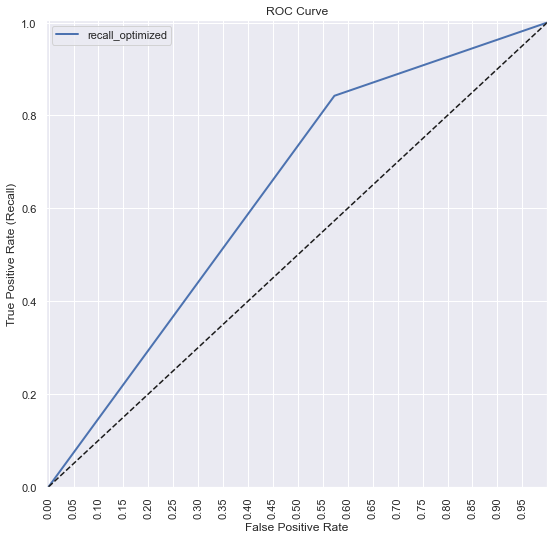

In [95]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, ypredk)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/KNN ROC Curve.png')

In [96]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, ypredk)

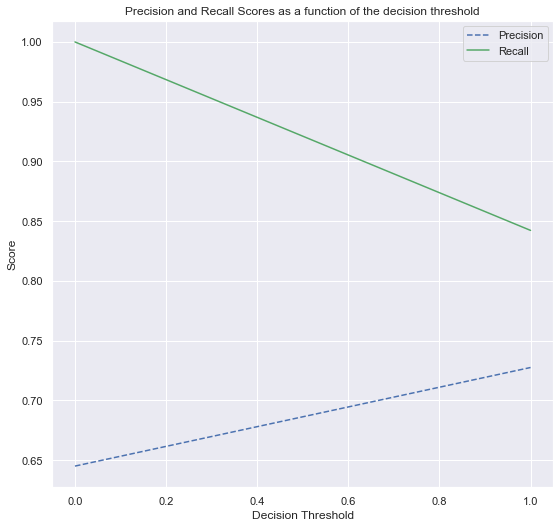

In [97]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold KNN.png')

### KNN Hyperparameter Tuning

In [98]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#List Hyperparameters yang akan diuji
n_neighbors = list(range(1,30))
p=[1,2]
algorithm=['auto', 'ball_tree', 'kd_tree', 'brute']

#Menjadikan ke dalam bentuk dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm)

# Init Logres dengan Gridsearch, cross validation = 5
knn2 = KNeighborsClassifier()
clf3 = RandomizedSearchCV(knn2, hyperparameters, cv=5, random_state=42)

#Fitting Model
knn_model2 = clf.fit(xtrain, ytrain)

#Prediksi menggunakan model baru
ypredknn = knn_model2.predict(xtest)#Check performa dari model
print('\nclassification report')
print(classification_report(ytest, ypredknn)) # generate the precision, recall, f-1 score, num
print('KNN: ROC AUC = ',str(round(roc_auc_score(ytest, ypredknn)*100,1)), '%')
print('KNN: Precision = ',str(round(precision_score(ytest, ypredknn)*100,1)), '%')
print('KNN: Recall = ',str(round(recall_score(ytest, ypredknn)*100,1)), '%')
print('KNN: Accuracy = ',str(round(accuracy_score(ytest, ypredknn)*100,1)), '%')
print('KNN: F1-Score = ',str(round(f1_score(ytest, ypredknn)*100,1)), '%')
confusion_matrix(ytest, ypredknn)


classification report
              precision    recall  f1-score   support

           0       0.82      0.60      0.70       164
           1       0.81      0.93      0.87       298

    accuracy                           0.81       462
   macro avg       0.82      0.77      0.78       462
weighted avg       0.82      0.81      0.81       462

KNN: ROC AUC =  76.7 %
KNN: Precision =  81.0 %
KNN: Recall =  93.0 %
KNN: Accuracy =  81.4 %
KNN: F1-Score =  86.6 %


array([[ 99,  65],
       [ 21, 277]], dtype=int64)

In [99]:
#Save Machine Learning Model
import pickle
pickle.dump(knn_model2, open('KNN_model.pkl', 'wb'))

In [100]:
#Load and print model score
loaded_model = pickle.load(open('KNN_model.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.8138528138528138


In [101]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  100.0 %
test score :  81.39 %


ROC AUC Score:  76.7 %


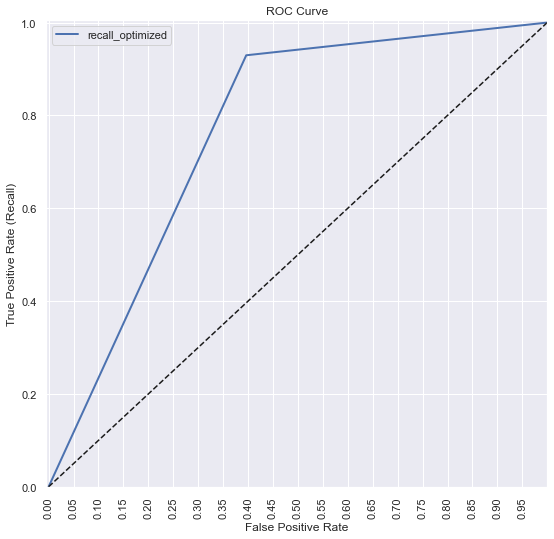

In [102]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, ypredknn)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/KNN ROC Curve.png')

In [103]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, ypredknn)

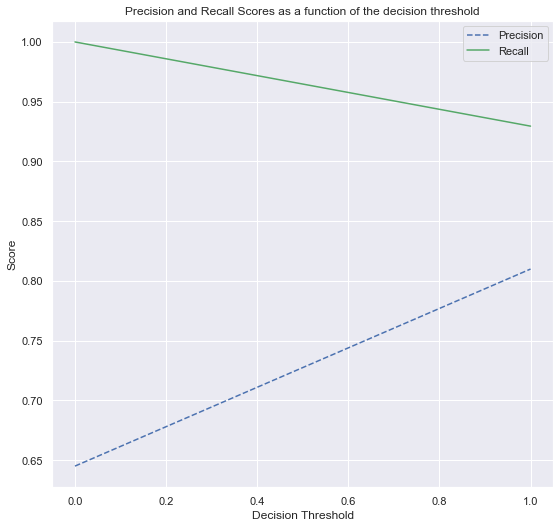

In [104]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold KNN.png')

## XGBoost

In [105]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

xgb_classifier = xgb.XGBClassifier()
norm_model = xgb_classifier.fit(xtrain, ytrain)
ypred_x = norm_model.predict(xtest)

print("\nClassification Report")
print(classification_report(ytest, ypred_x))
print('XGBoost: ROC AUC = ', str(round(roc_auc_score(ytest, ypred_x)*100,1)),"%")
print('XGBoost: Precision = ', str(round(precision_score(ytest, ypred_x)*100,1)),"%")
print('XGBoost: Recall = ', str(round(recall_score(ytest, ypred_x)*100,1)),"%")
print('XGBoost: Accuracy = ', str(round(accuracy_score(ytest, ypred_x)*100,1)),"%")
print("XGBoost: F1 Score =  ", str(round(f1_score(ytest, ypred_x)*100,1)),"%")
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, ypred_x)



Classification Report
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       164
           1       0.83      0.94      0.88       298

    accuracy                           0.84       462
   macro avg       0.84      0.80      0.81       462
weighted avg       0.84      0.84      0.83       462

XGBoost: ROC AUC =  79.7 %
XGBoost: Precision =  83.3 %
XGBoost: Recall =  93.6 %
XGBoost: Accuracy =  83.8 %
XGBoost: F1 Score =   88.2 %


array([[108,  56],
       [ 19, 279]], dtype=int64)

In [106]:
print("\nTrain vs Test Accuration")
import pickle
pickle.dump(xgb_classifier, open('XGBoost.pkl', 'wb'))

loaded_model = pickle.load(open('XGBoost.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)

print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')


Train vs Test Accuration
train score :  95.23 %
test score :  83.77 %


ROC AUC Score:  79.7 %


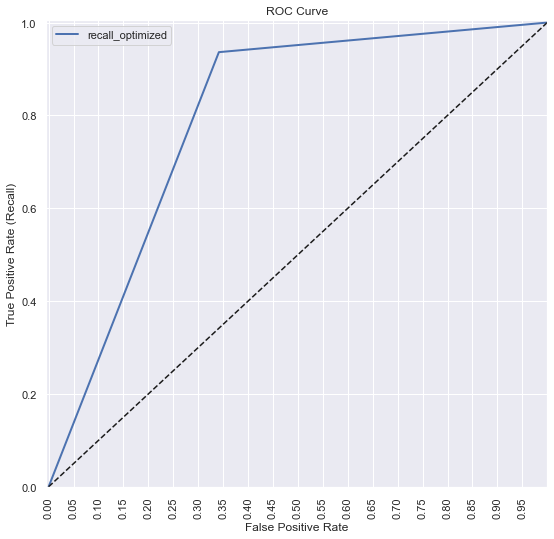

In [107]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, ypred_x)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/KNN ROC Curve.png')

In [108]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, ypred_x)

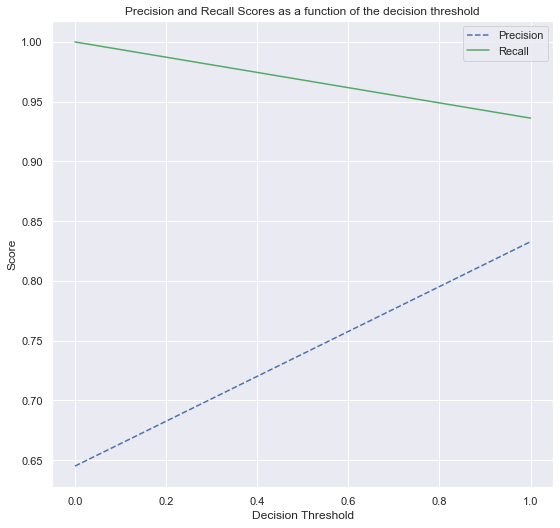

In [109]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold KNN.png')

### XGBoost Hyperparameter Tuning

In [110]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

hyperparameters = {
                    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                    "max_depth": [ 3, 4, 5, 6, 8, 10, 12, 15],
                    "min_child_weight": [ 1, 3, 5, 7 ],
                    "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                    "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7 ],
                    "eta":[.3, .2, .1, .05, .01, .005]
                  }

xgb_class = xgb.XGBClassifier(scale_pos_weight = 2)
clf4 = RandomizedSearchCV(xgb_class, hyperparameters, cv=5)
xgb_model = xgb_class.fit(xtrain, ytrain)
ypred_xgb = xgb_model.predict(xtest)

print("\nClassification Report")
print(classification_report(ytest, ypred_xgb))
print('XGBoost: ROC AUC = ', str(round(roc_auc_score(ytest, ypred_xgb)*100,1)),"%")
print('XGBoost: Precision = ', str(round(precision_score(ytest, ypred_xgb)*100,1)),"%")
print('XGBoost: Recall = ', str(round(recall_score(ytest, ypred_xgb)*100,1)),"%")
print('XGBoost: Accuracy = ', str(round(accuracy_score(ytest, ypred_xgb)*100,1)),"%")
print("XGBoost: F1 Score =  ", str(round(f1_score(ytest, ypred_xgb)*100,1)),"%")
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, ypred_xgb)


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.60      0.72       164
           1       0.81      0.96      0.88       298

    accuracy                           0.83       462
   macro avg       0.85      0.78      0.80       462
weighted avg       0.84      0.83      0.82       462

XGBoost: ROC AUC =  78.0 %
XGBoost: Precision =  81.4 %
XGBoost: Recall =  95.6 %
XGBoost: Accuracy =  83.1 %
XGBoost: F1 Score =   88.0 %


array([[ 99,  65],
       [ 13, 285]], dtype=int64)

In [111]:
print("\nTrain vs Test Accuration")
import pickle
pickle.dump(xgb_model, open('XGBoost_model.pkl', 'wb'))

loaded_model = pickle.load(open('XGBoost_model.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)

print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')


Train vs Test Accuration
train score :  92.84 %
test score :  83.12 %


ROC AUC Score:  78.0 %


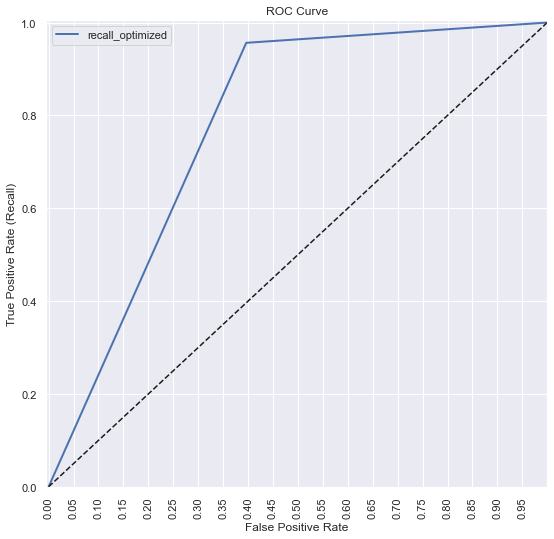

In [112]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, ypred_xgb)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/KNN ROC Curve.png')

In [113]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, ypred_xgb)

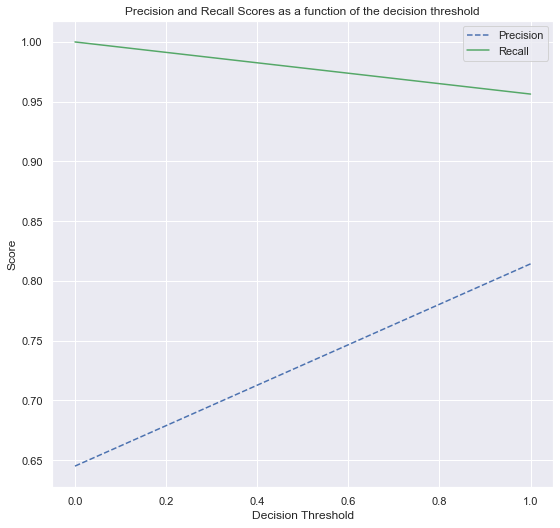

In [114]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold KNN.png')

# Predictions

## Random Forest Model

In [115]:
data_test_ori = pd.read_csv("startup data.csv")
loaded_model = pickle.load(open('RandomForest_model.pkl', 'rb'))
prediction = loaded_model.predict(x)
data_test_ori['prediction'] = prediction
data_test_ori['success'] = np.where(data_test_ori['prediction']==1,'success','fail')
success_startup = data_test_ori[data_test_ori['success']=='success']
percent_predict = round(((len(success_startup))/(len(data_test_ori)))*100,2)
percent_real = round((len(acquired)/len(data))*100,2)
score_diff = abs(percent_predict-percent_real)
num_diff = round((round(score_diff,2)/100)*len(data_test_ori))
print('The percentage of successfull startup is ' + str(percent_predict) + '%')
print('The number of startup which predicted success using Random Forest model are', str(len(success_startup)),'out of', str(len(data_test_ori)), 'startups')
print('Score difference between prediction and real percentage is', str(round(score_diff,2)), '%')
print("It's about", str(num_diff),'startups that supposed to be failed but predicted success by the model')

The percentage of successfull startup is 69.45%
The number of startup which predicted success using Random Forest model are 641 out of 923 startups
Score difference between prediction and real percentage is 4.77 %
It's about 44 startups that supposed to be failed but predicted success by the model


## XGBoost Model

In [116]:
data_test_ori = pd.read_csv("startup data.csv")
loaded_model = pickle.load(open('XGBoost_model.pkl', 'rb'))
prediction = loaded_model.predict(x)
data_test_ori['prediction'] = prediction
data_test_ori['success'] = np.where(data_test_ori['prediction']==1,'success','fail')
success_startup = data_test_ori[data_test_ori['success']=='success']
percent_predict = round(((len(success_startup))/(len(data_test_ori)))*100,2)
percent_real = round((len(acquired)/len(data))*100,2)
score_diff = abs(percent_predict-percent_real)
num_diff = round((round(score_diff,2)/100)*len(data_test_ori))
print('The percentage of successfull startup is ' + str(percent_predict) + '%')
print('The number of startup which predicted success using XGBoost model are', str(len(success_startup)),'out of', str(len(data_test_ori)), 'startups')
print('Score difference between prediction and real percentage is', str(round(score_diff,2)), '%')
print("It's about", str(num_diff),'startups that supposed to be failed but predicted success by the model')

The percentage of successfull startup is 73.89%
The number of startup which predicted success using XGBoost model are 682 out of 923 startups
Score difference between prediction and real percentage is 9.21 %
It's about 85 startups that supposed to be failed but predicted success by the model


## Decision Tree Model

In [117]:
data_test_ori = pd.read_csv("startup data.csv")
loaded_model = pickle.load(open('DecisionTree.pkl', 'rb'))
prediction = loaded_model.predict(x)
data_test_ori['prediction'] = prediction
data_test_ori['success'] = np.where(data_test_ori['prediction']==1,'success','fail')
success_startup = data_test_ori[data_test_ori['success']=='success']
percent_predict = round(((len(success_startup))/(len(data_test_ori)))*100,2)
percent_real = round((len(acquired)/len(data))*100,2)
score_diff = abs(percent_predict-percent_real)
num_diff = round((round(score_diff,2)/100)*len(data_test_ori))
print('The percentage of successfull startup is ' + str(percent_predict) + '%')
print('The number of startup which predicted success using Decision Tree model are', str(len(success_startup)),'out of', str(len(data_test_ori)), 'startups')
print('Score difference between prediction and real percentage is', str(round(score_diff,2)), '%')
print("It's about", str(num_diff),'startups that supposed to be failed but predicted success by the model')

The percentage of successfull startup is 64.68%
The number of startup which predicted success using Decision Tree model are 597 out of 923 startups
Score difference between prediction and real percentage is 0.0 %
It's about 0 startups that supposed to be failed but predicted success by the model


## Logistic Regression Model

In [118]:
data_test_ori = pd.read_csv("startup data.csv")
loaded_model = pickle.load(open('Logreg.pkl', 'rb'))
prediction = loaded_model.predict(x)
data_test_ori['prediction'] = prediction
data_test_ori['success'] = np.where(data_test_ori['prediction']==1,'success','fail')
success_startup = data_test_ori[data_test_ori['success']=='success']
percent_predict = round(((len(success_startup))/(len(data_test_ori)))*100,2)
percent_real = round((len(acquired)/len(data))*100,2)
score_diff = abs(percent_predict-percent_real)
num_diff = round((round(score_diff,2)/100)*len(data_test_ori))
print('The percentage of successfull startup is ' + str(percent_predict) + '%')
print('The number of startup which predicted success using Logistic Regression model are', str(len(success_startup)),'out of', str(len(data_test_ori)), 'startups')
print('Score difference between prediction and real percentage is', str(round(score_diff,2)), '%')
print("It's about", str(num_diff),'startups that supposed to be failed but predicted success by the model')

The percentage of successfull startup is 74.54%
The number of startup which predicted success using Logistic Regression model are 688 out of 923 startups
Score difference between prediction and real percentage is 9.86 %
It's about 91 startups that supposed to be failed but predicted success by the model


## KNN Model

In [119]:
data_test_ori = pd.read_csv("startup data.csv")
loaded_model = pickle.load(open('KNN_model.pkl', 'rb'))
prediction = loaded_model.predict(x)
data_test_ori['prediction'] = prediction
data_test_ori['success'] = np.where(data_test_ori['prediction']==1,'success','fail')
success_startup = data_test_ori[data_test_ori['success']=='success']
percent_predict = round(((len(success_startup))/(len(data_test_ori)))*100,2)
percent_real = round((len(acquired)/len(data))*100,2)
score_diff = abs(percent_predict-percent_real)
num_diff = round((round(score_diff,2)/100)*len(data_test_ori))
print('The percentage of successfull startup is ' + str(percent_predict) + '%')
print('The number of startup which predicted success using K-Nearest Neighbors model are', str(len(success_startup)),'out of', str(len(data_test_ori)), 'startups')
print('Score difference between prediction and real percentage is', str(round(score_diff,2)), '%')
print("It's about", str(num_diff),'startups that supposed to be failed but predicted success by the model')

The percentage of successfull startup is 69.45%
The number of startup which predicted success using K-Nearest Neighbors model are 641 out of 923 startups
Score difference between prediction and real percentage is 4.77 %
It's about 44 startups that supposed to be failed but predicted success by the model
